In [168]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import pandas as pd
import numpy as np

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 21)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
# no noise
#train_y = torch.sin(train_x * (2 * math.pi)) * math.sqrt(0.04)

print(train_x.shape)
print(train_y.shape)

minx = torch.min(train_x)
maxx = torch.max(train_x)

print(minx, maxx)

filename = "N2N2_dataset.xls"

FACTOR = 1.0
dfin = pd.read_excel(filename)

dfdict = {}
min = float("inf")
max = float("-inf")
for c in dfin.columns:
    dfdict[c] = []
    if c == "vibrational level v\Temperature(K)":
        dfdict[c] = list(dfin[c].values)
    else:
        for v in dfin[c].values:
            val = FACTOR*v
            if val > max:
                max = val
            if val < min:
                min = val

for c in dfin.columns:
    if c != "vibrational level v\Temperature(K)":
        for v in dfin[c].values:
            val = FACTOR*v
            valp = (val - min) / (max - min)
            # non normalize
            dfdict[c].append(val)
            # normalize
            #dfdict[c].append(valp)

df = pd.DataFrame.from_dict(dfdict)

vib= []
for v in df["vibrational level v\Temperature(K)"].values:
    vib.append(float(v))
    #print("\"",v,"\"")

y = []
x = []

tvals = df.columns[1:]
tvals = df.columns[1:2]

for t in tvals:
    T = float(t)
    #print(T)
    for idx in range(len(vib)):
        #print(T, vib[idx])
        #x.append([T, vib[idx]])
        x.append(vib[idx])
        yval = df[t].values[idx]
        yval = math.log(yval)
        y.append(yval)

for i in range(len(x)):
    train_x[i] = x[i]
    train_y[i] = y[i]

#train_x = torch.from_numpy(np.array(x))
#train_y = torch.from_numpy(np.array(y))

print(train_x.shape)
print(train_y.shape)

minx = torch.min(train_x)
maxx = torch.max(train_x)

print(minx, maxx)


torch.Size([21])
torch.Size([21])
tensor(0.) tensor(1.)
torch.Size([21])
torch.Size([21])
tensor(1.) tensor(40.)


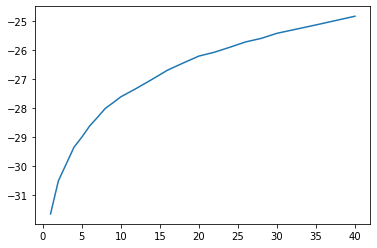

In [170]:
plt.plot(train_x, train_y)

In [171]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [172]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 5000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/5000 - Loss: 241.050   lengthscale: 0.693   noise: 0.693
Iter 2/5000 - Loss: 218.494   lengthscale: 0.744   noise: 0.744
Iter 3/5000 - Loss: 198.065   lengthscale: 0.798   noise: 0.798
Iter 4/5000 - Loss: 179.596   lengthscale: 0.854   noise: 0.853
Iter 5/5000 - Loss: 162.955   lengthscale: 0.913   noise: 0.910
Iter 6/5000 - Loss: 148.028   lengthscale: 0.974   noise: 0.968
Iter 7/5000 - Loss: 134.703   lengthscale: 1.037   noise: 1.027
Iter 8/5000 - Loss: 122.861   lengthscale: 1.101   noise: 1.086
Iter 9/5000 - Loss: 112.372   lengthscale: 1.168   noise: 1.145
Iter 10/5000 - Loss: 103.100   lengthscale: 1.235   noise: 1.204
Iter 11/5000 - Loss: 94.913   lengthscale: 1.304   noise: 1.262
Iter 12/5000 - Loss: 87.681   lengthscale: 1.373   noise: 1.319
Iter 13/5000 - Loss: 81.285   lengthscale: 1.442   noise: 1.375
Iter 14/5000 - Loss: 75.619   lengthscale: 1.511   noise: 1.430
Iter 15/5000 - Loss: 70.587   lengthscale: 1.580   noise: 1.483
Iter 16/5000 - Loss: 66.107   lengthsca

In [175]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(minx, maxx+10, 11)
    print(test_x)
    print(test_x.shape, type(test_x))
    observed_pred = likelihood(model(test_x))



tensor([ 1.0000,  5.9000, 10.8000, 15.7000, 20.6000, 25.5000, 30.4000, 35.3000,
        40.2000, 45.1000, 50.0000])
torch.Size([11]) <class 'torch.Tensor'>


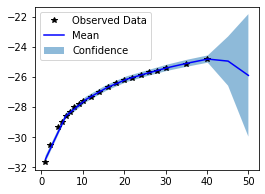

In [177]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
     # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

